<a href="https://colab.research.google.com/github/Ali-Asgar-Lakdawala/Forcasting/blob/main/Monthly_milk_production_forcast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/Ali-Asgar-Lakdawala/Forcasting/main/data/monthlyMilkProduction.csv')

In [3]:
df['Month']=pd.to_datetime(df['Month'])

In [4]:
df=df.set_index(df['Month']).drop('Month',axis=1)

In [5]:
df

,Monthly milk production
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1975-08-01,858
1975-09-01,817
1975-10-01,827


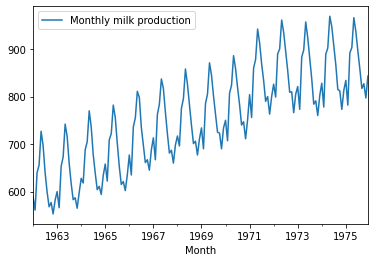

In [6]:
df.plot()

In [7]:
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
adfuller(df['Monthly milk production'])

(-1.3038115874221299,
 0.6274267086030314,
 13,
 154,
 {'1%': -3.473542528196209,
  '10%': -2.576878053634677,
  '5%': -2.880497674144038},
 1115.1730447395112)

In [9]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [10]:
adfuller_test(df['Monthly milk production'])

ADF Test Statistic : -1.3038115874221299
p-value : 0.6274267086030314
#Lags Used : 13
Number of Observations Used : 154
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [11]:
df['first_dif']=df['Monthly milk production']-df['Monthly milk production'].shift(1)
df['seasonal_dif']=df['first_dif']-df['first_dif'].shift(12)

In [12]:
adfuller_test(df['seasonal_dif'].dropna())

ADF Test Statistic : -5.038002274921983
p-value : 1.865423431878848e-05
#Lags Used : 11
Number of Observations Used : 143
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [13]:
df['seasonal_dif']

Month
1962-01-01     NaN
1962-02-01     NaN
1962-03-01     NaN
1962-04-01     NaN
1962-05-01     NaN
              ... 
1975-08-01     3.0
1975-09-01    11.0
1975-10-01    13.0
1975-11-01     9.0
1975-12-01     6.0
Name: seasonal_dif, Length: 168, dtype: float64

In [14]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [15]:
import matplotlib.pyplot as plt


p,d,q p

p AR model lags 
 
d differencing 
 
q MA lags

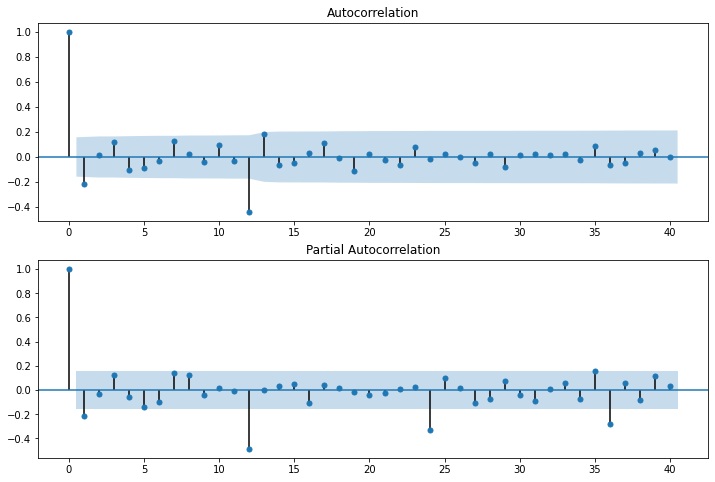

In [16]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['seasonal_dif'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['seasonal_dif'].iloc[13:],lags=40,ax=ax2)

In [17]:
# setting initial values and some bounds for them
ps = range(1, 4)
d=1 
qs = range(1, 4)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 12 # season length is still 24

# creating list with all the possible combinations of parameters
from itertools import product 
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [18]:
import statsmodels.api as sm

In [19]:
# from statsmodels.api.tsa.stattools import SARIMAX
from tqdm import tqdm_notebook
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for ps, qs, Ps, Qs in parameters_list:
      # we need try-except because on some combinations model fails to converge
      
      model=sm.tsa.statespace.SARIMAX(df['Monthly milk production'], order=(ps, d, qs),seasonal_order=(Ps, D, Qs, s))
      model=model.fit()   

      aic = model.aic
      # saving best model, AIC and parameters
      if aic < best_aic:
          best_model = model
          best_aic = aic
          best_param = ps, qs, Ps, Qs
      results.append([[ps, qs, Ps, Qs], model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [20]:
# %%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

In [21]:
result_table.head()

,parameters,aic
0,"[2, 1, 0, 1]",1066.695673
1,"[1, 3, 0, 1]",1067.982420
2,"[1, 1, 0, 1]",1068.063954
3,"[2, 2, 0, 1]",1068.466615
4,"[2, 1, 1, 1]",1068.472069


In [22]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df['Monthly milk production'], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                 Statespace Model Results                                 
Dep. Variable:            Monthly milk production   No. Observations:                  168
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -528.348
Date:                            Sat, 29 Jan 2022   AIC                           1066.696
Time:                                    10:05:25   BIC                           1081.913
Sample:                                01-01-1962   HQIC                          1072.877
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1558      0.097    -11.874      0.000      -1.347      -0.965
ar.L2         -0.2629      0.085   

In [40]:
import pickle

In [41]:
with open('milk_forcast_sarima.pkl','wb') as sarima:
  pickle.dump(best_model,sarima)

In [43]:
with open('milk_forcast_sarima.pkl', 'rb') as sarima:
    saved_sarima = pickle.load(sarima)

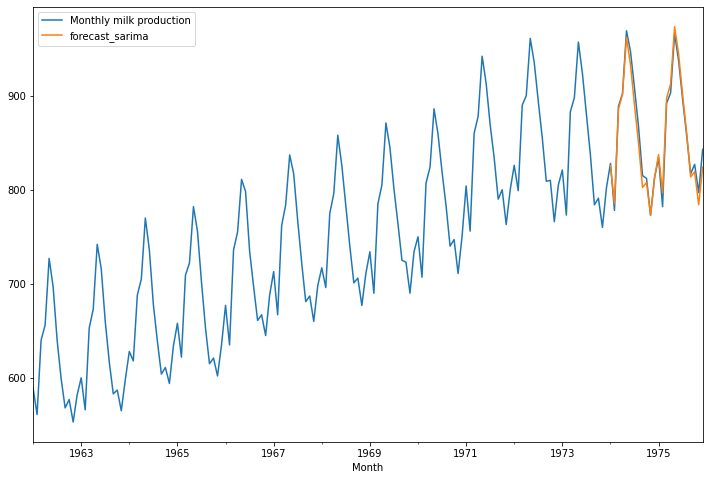

In [44]:
df['forecast_sarima']=saved_sarima.predict(start=144,end=190,dynamic=True)
df[['Monthly milk production','forecast_sarima']].plot(figsize=(12,8))


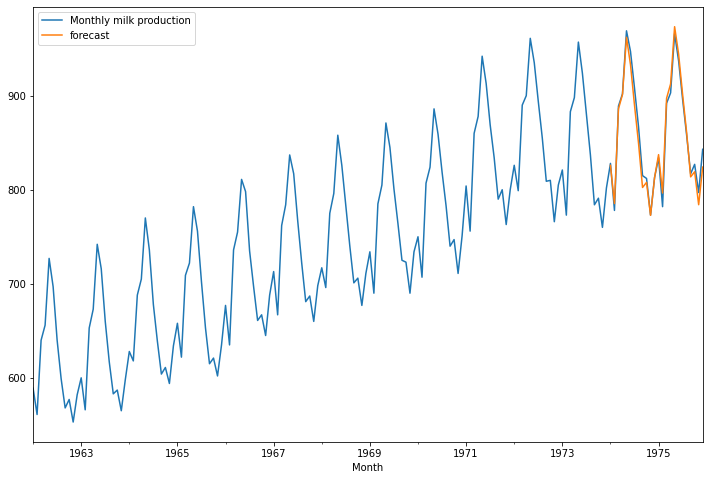

In [23]:
df['forecast_sarima']=best_model.predict(start=144,end=190,dynamic=True)
df[['Monthly milk production','forecast_sarima']].plot(figsize=(12,8))


In [32]:
from sklearn.metrics import mean_squared_error

In [35]:
mse=mean_squared_error(df['Monthly milk production'].iloc[144:],df['forecast_sarima'].iloc[144:])

In [38]:
import math
math.sqrt(mse)

9.58999521550193

In [31]:
df[['Monthly milk production','forecast_sarima']].iloc[144:]

,Monthly milk production,forecast
Month,,
1974-01-01,828,825.875821
1974-02-01,778,785.323671
1974-03-01,889,886.035366
1974-04-01,902,901.229409
1974-05-01,969,962.088631
1974-06-01,947,932.932771
1974-07-01,908,889.788058
1974-08-01,867,849.493730
1974-09-01,815,802.401840


In [24]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [25]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [26]:
future_df=pd.concat([df,future_datest_df])

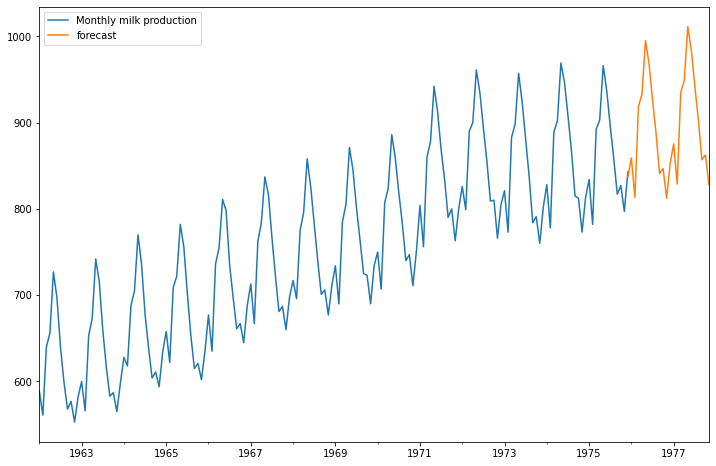

In [27]:
future_df['forecast_sarima']=best_model.predict(start=167,end=190,dynamic=True)
future_df[['Monthly milk production','forecast_sarima']].plot(figsize=(12,8))


# FbProphet

In [47]:
fb_df=pd.read_csv('https://raw.githubusercontent.com/Ali-Asgar-Lakdawala/Forcasting/main/data/monthlyMilkProduction.csv')

In [48]:
fb_df['Month']=pd.to_datetime(fb_df['Month'])

In [49]:
fb_df

,Month,Monthly milk production
0,1962-01-01,589
1,1962-02-01,561
2,1962-03-01,640
3,1962-04-01,656
4,1962-05-01,727
...,...,...
163,1975-08-01,858
164,1975-09-01,817
165,1975-10-01,827
166,1975-11-01,797


In [51]:
fb_df.columns=["ds","y"]

In [52]:
fb_df

,ds,y
0,1962-01-01,589
1,1962-02-01,561
2,1962-03-01,640
3,1962-04-01,656
4,1962-05-01,727
...,...,...
163,1975-08-01,858
164,1975-09-01,817
165,1975-10-01,827
166,1975-11-01,797


In [53]:
from fbprophet import Prophet

In [54]:
model=Prophet()
model.fit(fb_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [56]:
future_dates=model.make_future_dataframe(periods=365)

In [57]:
prediction=model.predict(future_dates)

In [59]:
prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1962-01-01,606.941323,577.167697,596.403644,606.941323,606.941323,-20.151798,-20.151798,-20.151798,-20.151798,-20.151798,-20.151798,0.0,0.0,0.0,586.789525
1,1962-02-01,608.656256,536.644636,555.311158,608.656256,608.656256,-62.588619,-62.588619,-62.588619,-62.588619,-62.588619,-62.588619,0.0,0.0,0.0,546.067637
2,1962-03-01,610.205228,631.254975,651.093453,610.205228,610.205228,31.365739,31.365739,31.365739,31.365739,31.365739,31.365739,0.0,0.0,0.0,641.570967
3,1962-04-01,611.920161,649.030335,668.130635,611.920161,611.920161,46.703773,46.703773,46.703773,46.703773,46.703773,46.703773,0.0,0.0,0.0,658.623935
4,1962-05-01,613.579774,711.973349,732.049150,613.579774,613.579774,108.040207,108.040207,108.040207,108.040207,108.040207,108.040207,0.0,0.0,0.0,721.619981


In [60]:
prediction[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
528,1976-11-26,815.347638,804.599690,826.059479
529,1976-11-27,818.479106,807.687450,829.486015
530,1976-11-28,821.790064,810.055412,833.199634
531,1976-11-29,825.219679,814.384217,836.130733
532,1976-11-30,828.699914,817.888963,839.932467


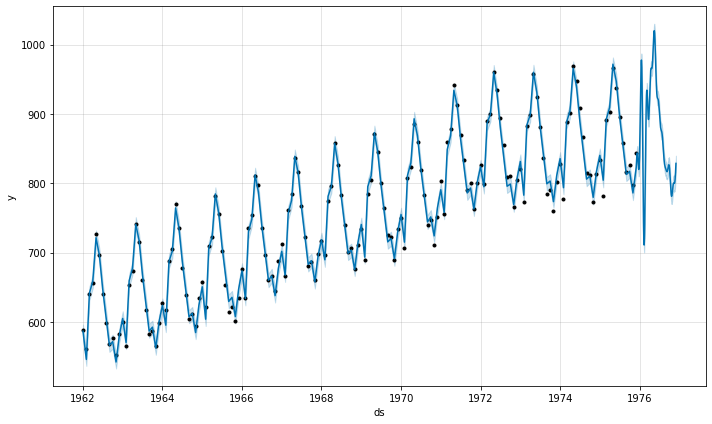

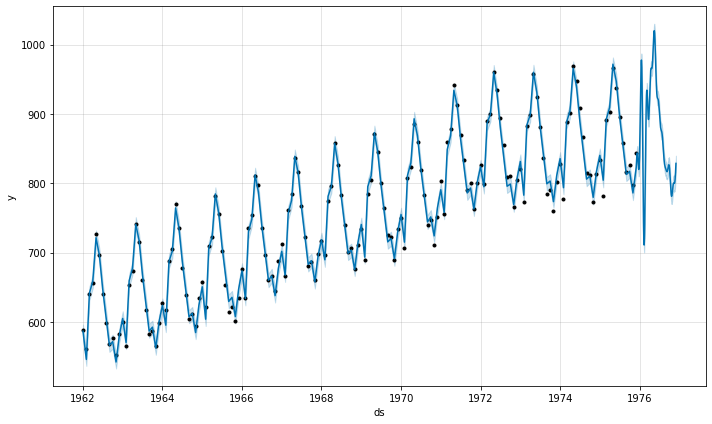

In [61]:
model.plot(prediction)

In [62]:
from fbprophet.diagnostics import cross_validation

In [63]:
df_cv=cross_validation(model,horizon="365 days",period='180 days',initial='1095 days')

INFO:fbprophet:Making 21 forecasts with cutoffs between 1965-01-22 00:00:00 and 1974-12-01 00:00:00


  0%|          | 0/21 [00:00<?, ?it/s]

In [66]:
import seaborn as sns

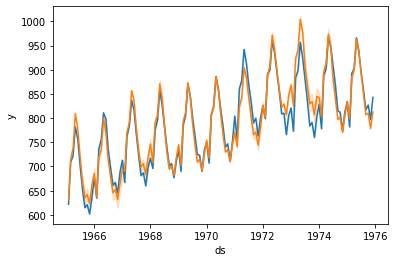

In [71]:
sns.lineplot(x='ds',y='y',data=df_cv)
sns.lineplot(x='ds',y='yhat',data=df_cv)

In [72]:
future_dates=model.make_future_dataframe(periods=365)

In [73]:
prediction=model.predict(future_dates)

In [74]:
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1962-01-01,606.941323,577.572749,596.121744,606.941323,606.941323,-20.151798,-20.151798,-20.151798,-20.151798,-20.151798,-20.151798,0.0,0.0,0.0,586.789525
1,1962-02-01,608.656256,536.706952,556.619365,608.656256,608.656256,-62.588619,-62.588619,-62.588619,-62.588619,-62.588619,-62.588619,0.0,0.0,0.0,546.067637
2,1962-03-01,610.205228,631.353538,651.570053,610.205228,610.205228,31.365739,31.365739,31.365739,31.365739,31.365739,31.365739,0.0,0.0,0.0,641.570967
3,1962-04-01,611.920161,648.440915,668.414015,611.920161,611.920161,46.703773,46.703773,46.703773,46.703773,46.703773,46.703773,0.0,0.0,0.0,658.623935
4,1962-05-01,613.579774,712.632758,731.024364,613.579774,613.579774,108.040207,108.040207,108.040207,108.040207,108.040207,108.040207,0.0,0.0,0.0,721.619981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,1976-11-26,875.028496,804.362488,826.874905,870.446104,879.339546,-59.680857,-59.680857,-59.680857,-59.680857,-59.680857,-59.680857,0.0,0.0,0.0,815.347638
529,1976-11-27,875.046715,807.278683,829.104139,870.440028,879.386293,-56.567609,-56.567609,-56.567609,-56.567609,-56.567609,-56.567609,0.0,0.0,0.0,818.479106
530,1976-11-28,875.064935,810.882338,832.990333,870.433953,879.433040,-53.274871,-53.274871,-53.274871,-53.274871,-53.274871,-53.274871,0.0,0.0,0.0,821.790064
531,1976-11-29,875.083154,813.911860,835.533394,870.427878,879.479787,-49.863476,-49.863476,-49.863476,-49.863476,-49.863476,-49.863476,0.0,0.0,0.0,825.219679


In [96]:
result = pd.concat([prediction, fb_df['y']], axis=1,)

In [98]:
result[['y','yhat']]

,y,yhat
0,589.0,586.789525
1,561.0,546.067637
2,640.0,641.570967
3,656.0,658.623935
4,727.0,721.619981
...,...,...
528,NaN,815.347638
529,NaN,818.479106
530,NaN,821.790064
531,NaN,825.219679


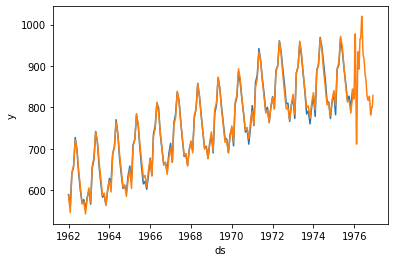

In [99]:
sns.lineplot(x='ds',y='y',data=result)
sns.lineplot(x='ds',y='yhat',data=result)

In [ ]:
prediction[['ds','yhat'